[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/gvarnavi/generative-art-iap/blob/master/01.26-Wednesday/01_mathematical-fractals-py.ipynb)

# Mathematical Fractals
"A fractal is a way of seeing infinity." ~ *Benoit Mandelbrot*

## Getting started
If working within Google Colaboratory, we need to clone the Github repo to access some supporting files for import.

In [ ]:
!git clone https://github.com/gvarnavi/generative-art-iap.git
%cd generative-art-iap/01.26-Wednesday

## Logistic map
Maps parameterized by a discrete-time parameter often take the form of iterated functions. One prototypical example is the **logistic map**,

$$ x_{n+1} = rx_n(1 - x_n),$$

where $r$ is a constant parameter, and $x_n$ lies on the interval $[0,1]$. To identify the unique properties of this system, we want to visualize how the map evolves with successive iterations as a function of the parameter $r$, and to determine the state of the system after many iterations.

We start by defining some library imports we will need in this notebook.

In [1]:
import numpy as np                                  # math operations (e.g. sine, cosine)
import ipywidgets as widgets                        # interactive controls
import gc                                           # garbage collector
from numba import njit                              # accelerate simple sequential operations
from mathematical_fractals_utils import *           # helper functions for plotting
from IPython.display import HTML                    # display movies
from google.colab import files                      # download files

Next, we want to define a function ```logistic``` which takes the parameter $r$ and current state $x$ and computes the next iterate of the logistic map.

In [2]:
def logistic(x, r):
    ''' Compute the next iterate of the logistic map. '''
    return r*x*(1 - x)

In [ ]:
logistic(0.25, 2.5)

Now, let's create a function `calc_trajectory(func, x0, N, args)` to perform the logistic map sequentially over $N$ iterations starting from the state $x_0$ and record the path taken. We will visualize the result by plotting $x_n$ on the x-axis and $x_{n+1}$ on the y-axis. The procedure is as follows:

1. Given the starting point $x=x_0$, evaluate $y=$ `logistic(x, r)` and record the value $(x, y)$.
2. Update the initial state by sending $y \rightarrow x$ and again record $(x, y)$.
3. Repeat the process, keeping track of $(x, y)$ at each step.

The function returns an array of all the recorded points after a specified number of iterations $N$.
Plotting this result produces a **cobweb plot** that is useful for analyzing the kinds of final states or **orbits** toward which the system evolves.

In [11]:
def calc_trajectory(fmap, x0, N, *args):
    ''' Evaluate the function fmap sequentially over N iterations and return an array of points of the path taken.
        Inputs:
            fmap - function of the iterative map
            x0 - initial value
            N  - number of iterations
            args - additional arguments taken by fmap
        Outputs:
            points - array of traversed points
    '''
    points = np.zeros((2*N, 2))           # array to store all (x,y) pairs
    x, y = x0, 0                          # initialization
    points[0,:] = [x, y]                  # store initial condition

    for i in range(1,N):
        y = fmap(x, *args)                # compute next iterate
        points[2*i-1,:] = [x, y]
        x = y                             # set next initial condition
        points[2*i,:] = [x, y]
    y = fmap(x, *args)                    # compute and record the final point
    points[-1,:] = [x, y]
    return points

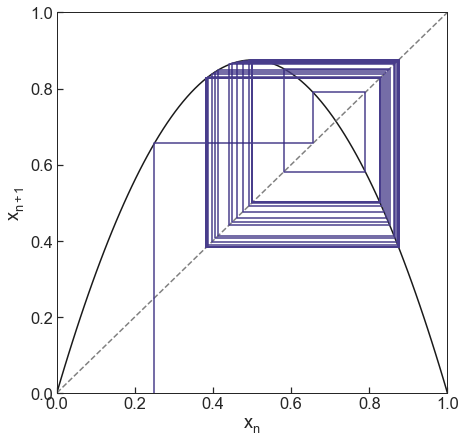

In [12]:
x0 = 0.25
r = 3.5
N = 100

# calculate trajectory
points = calc_trajectory(logistic, x0, N, r)

# display labeled cobweb plot
f, ax = cobweb_plot(logistic, points, r);

The cell below wraps the calls to `calc_trajectory` and `cobweb_plot` inside an interactive slider that can be used to explore the final orbits for different choices of $r$.

In [ ]:
r_slider = widgets.FloatSlider(value=2.5, min=1., max=4., step=0.01, description='r:', readout_format='.2f')
@widgets.interact(r = r_slider)
def cobweb_slider(r=2.5):
    points = calc_trajectory(logistic, x0, N, r)
    cobweb_plot(logistic, points, r)

For certain intervals of the parameter $r$, the map settles into periodic orbits about one or more fixed points, while in other cases, it behaves chaotically. These parameter intervals and the corresponding orbits can be visualized using an **orbit diagram**, which is a plot of the stable orbits $x$ at a particular value of the parameter $r$.

Let's write a function ```calc_orbits``` iterate through a transient of $400$ iterations and then output only the following $100$ iterations, for $1000$ different values of $r$ in the range $r=2.4$ to $r=4.0$.

In [13]:
def calc_orbits(out, fmap, x0, *args, warmup=400):
    ''' Iterate the function fmap through a transient of warmup iterations and return an array of the final orbits.
        Inputs:
            out - output array to store final orbits
            fmap - function of the iterative map
            x0 - initial value
            args - additional arguments taken by fmap
            warmup - number of transient iterations
    '''
    # iterate through transient behavior
    x = x0
    for i in range(warmup):
        x = fmap(x, *args)
        
    # output long-term behavior
    out[0] = fmap(x, *args)
    for i in range(len(out)-1):
        out[i+1] = fmap(out[i], *args)

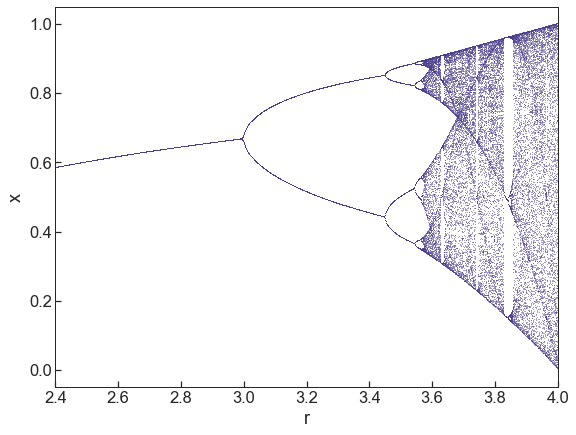

In [14]:
x0 = 0.5
r = np.linspace(2.4,4.,1000)           # range of r values
out = np.zeros((100, len(r)))          # initialize array to store output
calc_orbits(out, logistic, x0, r)      # calculate orbits

# display labeled orbit diagram
f, ax = orbit_diagram(out, r);

Note the bifurcations in the orbit diagram at values of $r$ where **period doubling** occurs. The orbit diagram is in fact **fractal**; if we zoom in, the diagram looks self-similar. This is a clue that chaotic maps can actually be used to generate fractals.

## Julia set
The **Julia set** is the set of initial points whose orbits remain bounded under iterations of a given map. As an example, let's look at the quadratic Julia set, which is the Julia set of the discrete two-dimensional map given by the family of complex quadratic polynomials:

$$z_{n+1} = z_n^2 + c,$$

where $z_n$ and $c$ are both complex.

To start, we define a function ```quadratic``` which takes as input the parameter $c$ and current state $z$ and computes the next iterate of the quadratic map. Note that the built-in function ```complex``` can be used to create a complex number given a real part $x$ and imaginary part $y$ as ```complex(x,y)```.

In [3]:
@njit
def quadratic(z, c):
    ''' Compute the next iterate of the discrete quadratic map. '''
    return z**2 + c

In [ ]:
quadratic(complex(1., 1.), complex(-0.4, 0.6))

To determine if a point is a member of the Julia set, we will create a function ```julia``` to iteratively call our map a specified number of times and return one of the following:
1. If upon iteration, a point goes beyond some escape radius $R$, we will call that orbit unbounded and return the number of iterations it took to escape.
2. If the point never escapes in the given number of steps, we simply return the maximum number of iterations.

In [4]:
@njit
def julia(fmap, z0, p, R=10, max_iters=500):
    ''' Determine whether a point z0 belongs to the Julia set of a function given a maximum number of iterations.
        Inputs:
            fmap - function of the iterative map
            z0 - initial value
            p - parameter(s) taken by fmap
            R - escape radius radius beyond which orbits are considered unbounded
            max_iters - maximum number of iterations
        Outputs:
            number of iterations required to escape (or max_iters if orbit remains bounded)
    '''
    z = z0
    for i in range(1, max_iters+1):
        z = fmap(z, p)
        if abs(z) >= R:
            return i
    return max_iters

In [ ]:
z0 = complex(1., 1.)
c = complex(-0.4, 0.6)
julia(quadratic, z0, c)

We are interested in the number of iterations required for escape for many different points. Since our map involves complex numbers, $z = x + iy$, we can represent these points in a two-dimensional space with the real and imaginary parts on the x- and y-axes, respectively.

Let's create a function ```make_fractal``` that takes a two-dimensional array of points $(x,y)$ representing the initial values $z_0 = x + iy$, and for each point calculates the output of ```julia``` (or a similar function, to be introduced later!). Since the Julia set is just one example of a set that generates a fractal, we will keep ```make_fractal``` generic by using the variable name ```fset``` for a function like ```julia```.

In [5]:
@njit
def make_fractal(out, fset, fmap, L, p, R=10, max_iters=500):
    ''' Compute the set fset of the function given by fmap for each point in a specified image domain.
        Inputs:
            out - two-dimensional output array
            fset - function of the set to compute (e.g. julia)
            fmap - function of the iterative map (e.g. quadratic)
            L - extent of image domain given by [-L,L]x[-L,L]
            p - parameter(s) taken by fmap
            R - escape radius radius beyond which orbits are considered unbounded
            max_iters - maximum number of iterations
    '''
    
    ny, nx = out.shape
    dx = 2*L/nx
    dy = 2*L/ny
    
    for i in range(nx):
        x = -L + i*dx
        for j in range(ny):
            y = -L + j*dy
            out[j,i] = fset(fmap, complex(x, y), p, R, max_iters)

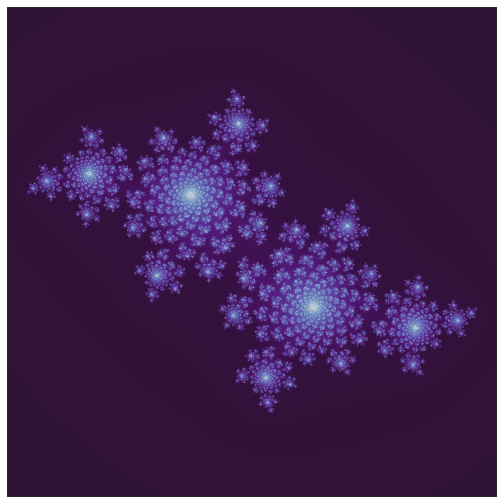

In [6]:
nx, ny = 1000, 1000
out = np.zeros((nx, ny), dtype=np.int64)
L = 1.5
c = complex(-0.4, 0.6)
make_fractal(out, julia, quadratic, L, c)

# display image
f, ax = fractal_plot(out, palette='default');

Larger ```nx```, ```ny```, and ```max_iters``` allow you to resolve more details but will take longer to run. You can change the color palette used for plotting by changing the ```palette``` argument to the name of one of these [colormaps](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html).

To save an image, you can run a ``f.savefig`` command like the following, where ```f``` is the handle to the figure object, i.e. ```f, ax = fractal_plot(out)```. It will be saved in the same directory as this notebook and should appear in the Jupyter navigation window, where you can select it and download it. If working within Google Colaboratory, you can also use the second line to download the saved image.

In [ ]:
f.savefig('my_figure.png', dpi=400)
files.download('my_figure.png')

Explore the kinds of fractals generated by different values of the constant $c$ using the widget below.

In [ ]:
nx, ny = 1000, 1000
out = np.zeros((nx, ny), dtype=np.int64)
L = 1.5

@widgets.interact_manual(c = ['romanesco', 'paisley', 'snowflake', 'vortices'])
def quadratic_julia_dropdown(c='romanesco'):   
    # suggested parameter sets
    romanesco = complex(-0.4, 0.6)
    paisley = complex(0.285, 0.01)
    snowflake = complex(-0.59, 0.49)
    vortices = complex(-0.8, 0.156)
    
    make_fractal(out, julia, quadratic, L, eval(c))
    fractal_plot(out, palette='default')
    gc.collect()

Use the sliders to find some other interesting patterns.

In [ ]:
nx, ny = 1000, 1000
out = np.zeros((nx, ny), dtype=np.int64)
L = 1.5

re_slider = widgets.FloatSlider(value=-0.4, min=-1., max=1., step=0.01, description='Re[c]:', readout_format='.2f')
im_slider = widgets.FloatSlider(value=0.6, min=-1., max=1., step=0.01, description='Im[c]:', readout_format='.2f')

@widgets.interact_manual(x=re_slider, y=im_slider)
def quadratic_julia_slider(x=-4., y=0.6):
    make_fractal(out, julia, quadratic, L, complex(x,y))
    fractal_plot(out, palette='default')
    gc.collect()

Now let's animate how the fractal patterns evolve as we gradually tune $c$. To make the movie, we'll want to build up a stack of fractal images with a frame for each value of $c$. This is handled by ```make_fractal_stack```.

In [ ]:
def make_fractal_stack(out, fset, fmap, L, ps, R=10, max_iters=500):
    ''' Compute the set fset of the function given by fmap for each point in a specified image domain.
        Inputs:
            out - two-dimensional output array
            fset - function of the set to compute (e.g. julia)
            fmap - function of the iterative map (e.g. quadratic)
            L - extent of image domain given by [-L,L]x[-L,L]
            ps - array of parameter(s) taken by fmap
            R - escape radius radius beyond which orbits are considered unbounded
            max_iters - maximum number of iterations
            frames - number of frames in the movie
    '''
    for i, p in enumerate(ps):
        make_fractal(out[:,:,i], fset, fmap, L, p, R=R, max_iters=max_iters)

We will sweep $c$ over the range $c = 0.7885e^{i \theta}$, with $\theta$ running from $0$ to $2 \pi$.

In [ ]:
frames = 50                            # number of frames

# make an array of constants c
T = np.linspace(0, 2*np.pi, frames)
cs = np.array([complex(0.7885*np.cos(t), 0.7885*np.sin(t)) for t in T])


# define a 3d array to store the movie
nx, ny = 500, 500
out = np.zeros((nx, ny, frames), dtype=np.int64)
L = 1.5

make_fractal_stack(out, julia, quadratic, L, cs, max_iters=100)

In [ ]:
ani = fractal_movie(out, palette='default')
HTML(ani.to_html5_video())

## Mandelbrot set
A complement to the Julia set is the **Mandelbrot set**, which is the parameter space of possible $c$ values for which the quadratic map remains bounded when initialized at $z_0 = 0 + 0i$.

Due to their similarity, we can can repurpose all our existing code when simulating the Mandelbrot set if we define our function ```mandel``` identically to ```julia```, but reverse the order of the arguments $z_0$ and $c$ in the function inputs. Then, we just need to remember to pass $z_0 = 0 + 0i$ for the initial value.

In [7]:
@njit
def mandel(fmap, p, z0, R=10, max_iters=50):
    ''' Determine whether a point p belongs to the Mandelbrot set of a function given a maximum number of iterations.
        Inputs:
            fmap - function of the iterative map
            p - parameter(s) taken by fmap
            z0 - initial value
            R - escape radius radius beyond which orbits are considered unbounded
            max_iters - maximum number of iterations
        Outputs:
            number of iterations required to escape (or max_iters if orbit remains bounded)
    '''
    z = z0
    for i in range(1, max_iters+1):
        z = fmap(z, p)
        if abs(z) >= R:
            return i
    return max_iters

Now we can visualize the Mandelbrot set reusing the ```quadratic``` and ```make_fractal``` functions defined earlier.

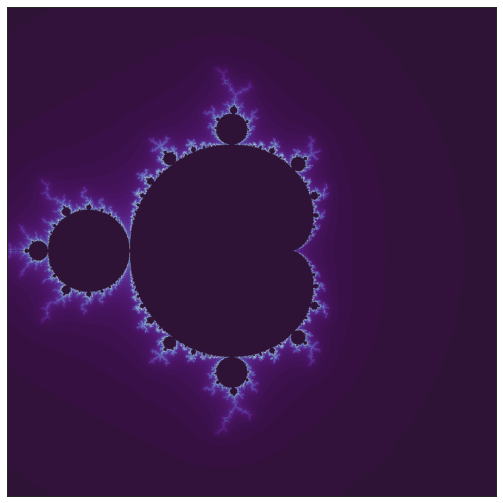

In [8]:
nx, ny = 1000, 1000
out = np.zeros((nx, ny), dtype=np.int64)
L = 1.5
z0 = complex(0., 0.)
make_fractal(out, mandel, quadratic, L, z0)

# display image
f, ax = fractal_plot(np.sqrt(out), palette='default');

### Interpretation
The image below notes the analogy between the Mandelbrot set and an orbit diagram. Each lobe in the Mandelbrot set corresponds to a parameter window of bounded orbits (trajectories that never escaped within the maximum number of iterations). The biggest lobe corresponds to a fixed point (orbit of period one), the second to an orbit with period two, and so on. This is reminiscent of the orbit diagram we made for the logistic map, except that instead of tuning one real parameter $r$, to construct the Mandelbrot set we tuned the complex parameter $c$.
![fractal summary](https://drive.google.com/uc?id=1VaiAzrereCNui6rTQn8_EE6UsrRyAJQ3)

### Blowing in the Wind

What happens if we make the initial point $z_0$ non-zero and compute its Mandelbrot set? The code below makes a video that sweeps $z_0$ along the diagonal from $0+0i$ to $1+i$. The Mandelbrot set looks like it's blowing away in the wind!

In [ ]:
# number of frames
frames = 50

# make an array of initial conditions z0
z0s = np.array([complex(i,i) for i in np.linspace(0,1,frames)])


# define a 3d array to store the movie
nx, ny = 500, 500
out = np.zeros((nx, ny, frames), dtype=np.int64)
L = 1.5

make_fractal_stack(out, mandel, quadratic, L, z0s, max_iters=50)

In [ ]:
ani = fractal_movie(out, palette='default')
HTML(ani.to_html5_video())

## Examples playground

Why not try and plot the Julia sets of other maps?
Let's try the function:

$$z_{n+1} = c\text{sin}(z_n)$$

In [ ]:
@njit
def sinusoid(z, c):
    return c*np.sin(z)

In [ ]:
nx, ny = 1000, 1000
out = np.zeros((nx, ny), dtype=np.int64)
c = complex(-0.2, 1.)
L = 1.5
make_fractal(out, julia, sinusoid, L, c, max_iters=200)

# display image
f, ax = fractal_plot(out, palette='default');

Play around with the extent $L$ of the image domain below.

In [ ]:
nx, ny = 1000, 1000
out = np.zeros((nx, ny), dtype=np.int64)

domain_slider = widgets.FloatSlider(value=1.5, min=0.2, max=10, step=0.1, description='L:', readout_format='.1f')
@widgets.interact_manual(L=domain_slider)
def sinusoid_julia_slider(L=1.5):
    make_fractal(out, julia, sinusoid, L, complex(-0.2, 1.), max_iters=200)
    fractal_plot(out, palette='default')
    gc.collect()

How about the complex analogue of the logistic map?

$$z_{n+1} = cz_n(1 - z_n)$$

In [ ]:
@njit
def complex_logistic(z, c):
    return c*z*(1 - z)

In [ ]:
nx, ny = 1000, 1000
out = np.zeros((nx, ny), dtype=np.int64)
c = complex(-0.2, 1.)
L = 0.2
make_fractal(out, julia, complex_logistic, L, c)

# display image
f, ax = fractal_plot(out, palette='default');

In [ ]:
nx, ny = 1000, 1000
out = np.zeros((nx, ny), dtype=np.int64)

domain_slider = widgets.FloatSlider(value=0.2, min=0.001, max=0.5, step=0.005, description='L:', readout_format='.3f')
@widgets.interact_manual(L=domain_slider)
def complex_logistic_julia_slider(L=0.2):
    make_fractal(out, julia, complex_logistic, L, complex(-0.2, 1.))
    fractal_plot(out, palette='default')
    gc.collect()